# Content Analysis of Tweets

In this notebook, we use the the distributed Latent Dirichlet Allocation PySpark MLLib to conduct topic analysis on the tweets that we have collected. In particular, we focus on English and Spanish language tweets. 

### Cluster Set Up for LDA

Set up for cluster:
```
gcloud beta dataproc clusters create ----cluster  --project PROJECT\
    --bucket ----bucket --region REGION \
    --image-version=preview \
    --optional-components=ANACONDA,JUPYTER \
    --enable-component-gateway \
    --initialization-actions \
    gs://goog-dataproc-initialization-actions-REGION/python/pip-install.sh,gs://----bucket/my-actions.sh \
    --metadata 'PIP_PACKAGES=sklearn nltk pandas numpy' 
```

`my-actions.sh`: initialisations to install the `nltk` package on all workers, found in the 

First, we import the data, in the same way as was done in the Graph Analysis notebook. We then prepare the data for topic modelling, extracting the text and pre-processing it, before running the LDA model on English and Spanish tweets in turn, for topic sizes of 10 and 20. Finally we embed the English and Spanish user graphs using the same method as in the Graph Analysis notebook, and colour the users according to the most prominent topic in one of their tweets.

In [1]:
from google.cloud import storage
import re
from time import time

client = storage.Client()
bucket = client.bucket('----bucket')
blobs = list(bucket.list_blobs(prefix='data/'))

files = ["gs://----bucket/" + str(blob.name) for blob in blobs if 'part-' in str(blob.name)]
data_from_file = sc.textFile(','.join(files))

rdd = data_from_file.coalesce(36).cache()
tweet_rdd = rdd.map(lambda row: [eval(item) if i > 2 else item for i, item in enumerate(row.split("\t\t"))]).cache()

columns = ['user_id', 'user', 'location', 'timestamp', 'tweet_id', 'retweet', 'text', 'language', 'user_mention_ids', 'user_mentions', 'hashtags', 'urls']
df = tweet_rdd.toDF(columns).distinct().cache()

In [2]:
import pandas as pd
import numpy as np
from time import time 
%matplotlib inline
import matplotlib.pyplot as plt
from pyspark.sql import Row
from pyspark.sql.functions import desc, first, col
#from graphframes import GraphFrame

In [4]:
#get tweet RDD: each row is a tweet and tweet/user properties
df_rdd = rdd.map(lambda x: (eval(x), identify_tweet(eval(x)))).filter(lambda x: x[1] is True).map(lambda x: get_tweet_row(x[0], "tweet")).cache()

#get tweet DF
columns = ['user_id', 'user', 'location', 'timestamp', 'tweet_id', 'retweet', 'text', 'language', 'user_mention_ids', 'user_mentions', 'hashtags', 'urls']
df = df_rdd.toDF(columns).cache()
df.take(3)

#get user vertices and edges
#user is a tweeter
#edge exists if mentioned another user
time0 = time()
vertices = rdd.map(lambda x: (eval(x), identify_tweet(eval(x)))).filter(lambda x: x[1] is True).flatMap(lambda x: get_tweet_row(x[0], "tweeter_vertices")).cache()
edges = rdd.map(lambda x: (eval(x), identify_tweet(eval(x)))).filter(lambda x: x[1] is True).flatMap(lambda x: get_tweet_row(x[0], "tweeter_edges")).cache()

verticesColumns = ['id']
edgesColumns = ['src', 'dst', 'timestamp', 'tweet_id', 'retweet', 'text', 'language', 'hashtags', 'urls']

verticesDF = vertices.map(lambda x: Row(x)).toDF(verticesColumns).distinct().cache()
allEdgesDF = edges.toDF(edgesColumns).distinct().cache()
#edgesDF = allEdgesDF.select("src", "dst").where(col("src")!=col("dst")).groupby("src", "dst").count().withColumnRenamed("count","weight")


## Prepare Data for Topic Modelling

We will perform LDA on the tweet text content. Each unique tweet is treated as a document.

First we tokenize the tweets:
- remove urls
- remove mentions to other users by the @ sign
- lemmatize/stem words depending on language and/or preference (Spanish does not have a lemmatizer in the nltk package)

We apply tokenising functions, and prepare the data for LDA using PySpark SQL DataFrame and RDD operations, switching between the two forms to attain the ideal format.

In [5]:
#Define function to delete tweets
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.stem.snowball import SnowballStemmer
import re,string
import nltk

def strip_links(text):
    """strips text of url links"""
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

def strip_all_entities(text):
    """strips text of @ signs"""
    entity_prefixes = ['@']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

es_stopwords = set(stopwords.words('spanish')).copy()
en_stopwords = set(stopwords.words('english')).copy()

def get_tokens(line, language, type = "lem"):
    
    #define the lemmatizer/stemmer
    if language == "es":
        stem_lem = SnowballStemmer("spanish")
        stop_words = es_stopwords
    elif type == "lem":
        stem_lem = WordNetLemmatizer() 
        stop_words = en_stopwords
    elif type == "stem":
        stem_lem = SnowballStemmer('english')
        stop_words = en_stopwords

    #get word tokens
    line = strip_all_entities(strip_links(line))
    tokens = line.split()
    tokens = [w.lower() for w in tokens]
    
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table).replace('”','').replace('“', '').replace('¡', '') for w in tokens]
    
    # filter out stop words
    words = [w for w in stripped if not w in stop_words]
    words = [stem_lem.lemmatize(word) for word in words] if type=="lem" else [stem_lem.stem(word) for word in words] 

    return words

In [ ]:
#get all distinct tweets with english and spanish
tweet_text_en_rdd = df.filter("language=='en'") \
  .select("tweet_id", "text", 'language') \
  .distinct() \
  .rdd.map(lambda row: (row["tweet_id"], get_tokens(row["text"], row["language"]))).cache()
       
tweet_text_es_rdd = df.filter("language=='es'") \
  .select("tweet_id", "text", 'language') \
  .distinct() \
  .rdd.map(lambda row: (row["tweet_id"], get_tokens(row["text"], row["language"], type = 'stem'))).cache()
    
print("Number of Unique English Tweets: {}".format(tweet_text_en_rdd.count()))
print("Number of Unique Spanish Tweets: {}".format(tweet_text_es_rdd.count()))

Number of Unique English Tweets: 334581
Number of Unique Spanish Tweets: 100436


Remove the domain specific stopwords for both English and Spanish datasets: we say that any word that appears more than 4000 times is a stopword.

In [ ]:
#Get stopwords: any word that occurs more than 4000 times
en_tweet_stop_words = tweet_text_en_rdd.flatMap(lambda r: r[1]).map(lambda r: (r,1)).reduceByKey(lambda a,b: a+b)
en_tweet_stop_words = en_tweet_stop_words.filter(lambda a: a[1]>4000).map(lambda r: r[0]).collect()

es_tweet_stop_words = tweet_text_es_rdd.flatMap(lambda r: r[1]).map(lambda r: (r,1)).reduceByKey(lambda a,b: a+b)
es_tweet_stop_words = es_tweet_stop_words.filter(lambda a: a[1]>4000).map(lambda r: r[0]).collect()

#Remove stopwords from vocabulary
tweet_text_en = tweet_text_en_rdd.map(lambda r: (r[0],[w for w in r[1] if not w in en_tweet_stop_words and not len(w)==1])) \
                                 .toDF(['tweet_id', 'text']).cache()
                                      
tweet_text_es = tweet_text_es_rdd.map(lambda r: (r[0],[w for w in r[1] if not w in es_tweet_stop_words and not len(w)==1])) \
                                 .toDF(['tweet_id', 'text']).cache()

print("Number of English Stopwords: {}".format(len(en_tweet_stop_words)))
print("Number of Spanish Stopwords: {}".format(len(es_tweet_stop_words)))
print("Some English Stopwords:")
print(en_tweet_stop_words[:50])
print("Some Spanish Stopwords:")
print(es_tweet_stop_words[:50])

Number of English Stopwords: 147
Number of Spanish Stopwords: 16
Some English Stopwords:
['', 'today', 'also', 'since', 'got', 'flu', 'hope', 'keep', 'china', 'go', 'world', 'fight', 'week', 'see', 'great', 'death', 'life', 'end', 'rate', 'right', 'vaccine', 'new', 'way', 'president', 'made', 'give', 'business', 'crisis', 'test', '2020', 'public', 'say', 'time', 'due', 'health', 'would', 'free', 'family', 'state', 'worker', 'read', '19', 'doctor', 'could', 'need', 'look', 'i’m', 'spread', 'much', 'covid']
Some Spanish Stopwords:
['pued', '19', 'salud', 'cas', 'hac', 'muert', 'gobiern', 'si', 'cov', 'pandemi', 'via', 'coronavirus', 'contagi', 'nuev', 'person', 'pais']


In [ ]:
from pyspark.ml.feature import CountVectorizer

en_cv = CountVectorizer(inputCol="text", outputCol="features",minDF=2)
en_cv_model = en_cv.fit(tweet_text_en)
en_tweet_features = en_cv_model.transform(tweet_text_en).cache()

es_cv = CountVectorizer(inputCol="text", outputCol="features",minDF=2)
es_cv_model = es_cv.fit(tweet_text_es)
es_tweet_features = es_cv_model.transform(tweet_text_es).cache()

In [ ]:
print("Size of English Vocabulary: {}".format(len(en_cv_model.vocabulary)))
print("Size of Spanish Vocabulary: {}".format(len(es_cv_model.vocabulary)))

Size of English Vocabulary: 65899
Size of Spanish Vocabulary: 26512


### English Topics

We fit two models, using the distributed LDA algorithm in the PySpark MLLib: one with 10 topics and one with 20.

In [ ]:
from pyspark.ml.clustering import LDA

en_lda10 = LDA(k=10, maxIter=5, seed=123)
en_lda20 = LDA(k=20, maxIter=5, seed=123)
en_lda_model10 = en_lda10.fit(en_tweet_features)
en_lda_model20 = en_lda20.fit(en_tweet_features)

In [ ]:
model_topics10 = en_lda_model10.describeTopics(5)#.show()
model_topics20 = en_lda_model20.describeTopics(5)#.show()

In [ ]:
import numpy as np
topic_en10 = model_topics10.select("termIndices").rdd.map(lambda r: r[0]).collect()
for i in topic_en10:
    print(np.array(en_cv_model.vocabulary)[i])

['se' 'warrior' 'hoax' 'force' 'biggest']
['house' 'johnson' 'next' 'boris' 'fauci']
['house' 'white' 'warren' 'buffett' 'berkshire']
['city' 'official' 'dr' 'confirmed' 'society']
['america' 'fund' 'administration' 'release' 'chinese']
['die' 'body' 'al' 'sorry' 'november']
['usa' '10' 'porn' 'old' 'governor']
['treatment' 'future' 'food' 'id' 'texas']
['high' 'school' 'getting' 'bill' 'system']
['check' '24' 'county' 'area' 'govt']


In [ ]:
topic_en20 = model_topics20.select("termIndices").rdd.map(lambda r: r[0]).collect()
for i in topic_en20:
    print(np.array(en_cv_model.vocabulary)[i])

['interesting' 'call' 'fuck' 'corona' 'drug']
['house' 'white' 'fauci' 'next' 'vote']
['house' 'recovery' 'white' 'amid' 'lay']
['dr' 'lab' 'wuhan' 'research' 'disease']
['release' 'mocking' 'propaganda' 'love' 'animated']
['force' 'armed' 'face' 'warrior' 'body']
['warrior' 'city' 'salute' '10' 'indian']
['biden' 'joe' 'dead' 'follow' 'claim']
['bill' 'high' 'covidー19' 'lot' 'system']
['check' 'fake' 'area' 'latest' 'county']
['app' 'mexico' 'road' 'airline' 'setu']
['war' 'challenge' 'killed' 'close' 'closed']
['usa' 'porn' 'york' 'antibody' 'america']
['confirmed' 'nigeria' 'bush' 'fear' 'face']
['watch' 'concert' 'posted' 'fund' 'article']
['order' '10' 'power' '24' 'intelligence']
['society' 'cashless' 'towards' 'jesus' 'future']
['county' 'anyone' 'die' 'story' 'treatment']
['vulnerable' 'official' 'protect' 'plan' 'buffett']
['hoax' 'recovered' 'oregon' 'july' 'brown']


### Spanish Models

We now do the same for the Spanish language tweets.

In [ ]:
es_lda10 = LDA(k=10, maxIter=5, seed=123)
es_lda_model10 = es_lda10.fit(es_tweet_features)
es_lda20 = LDA(k=20, maxIter=5, seed=123)
es_lda_model20 = es_lda20.fit(es_tweet_features)

In [ ]:
es_model_topics10 = es_lda_model10.describeTopics(5)#.show()
es_model_topics20 = es_lda_model20.describeTopics(5)#.show()

In [5]:
topic_es10 = es_model_topics10.select("termIndices").rdd.map(lambda r: r[0]).collect()
for i in topic_es10:
    print(np.array(es_cv_model.vocabulary)[i])


Spanish Topic Top 5 words                          | English translation
-----------------------------------------------------------------------------------------------------------
['dic' 'sanitari' 'trabaj' 'emergent' 'much']      | ['say' 'sanitary' 'word' 'mergent' 'much']
['ver' 'sol' 'dej' 'polit' 'buen']                 | ['see' 'only' 'leave' 'politic' 'good']
['000' 'fallec' 'mil' 'confirm' 'registr']         | ['000' 'die' 'thousand' 'confirm' 'registered'] 
['inform' 'may' 'hospital' 'ultim' 'trabaj']       | ['inform' 'may' 'hospital' 'last' 'work'] 
['trabaj' 'gent' 'ten' 'mas' 'baj']                | ['work' 'people' 'have' 'more' 'low'] 
['empres' 'chin' 'mat' 'recuper' 'quedateencas']   | ['company' 'china' 'kill' 'recover' 'stayathome'] 
['fallec' 'hospital' 'enferm' 'sab' 'graci']       | ['die' 'hospital' 'ill' 'know' 'thank']  
['trabaj' 'vend' 'ventil' 'mil'                    | ['work' 'sale' 'ventilator' 'thousand' 
                    'flexibilizacioncondiscipli

In [2]:
topic_es20 = es_model_topics20.select("termIndices").rdd.map(lambda r: r[0]).collect()
for i in topic_es20:
    print(np.array(es_cv_model.vocabulary)[i])


Spanish Topic Top 5 words                           | English translation
----------------------------------------------------------------------------------------------------------
['dic' 'gent' 'emergent' 'cos' 'mied']              | ['say' 'people' 'emergent' 'thing' 'fear']
['sol' 'polit' 'mejor' 'tom' 'dej']                 | ['only' 'polit' 'mejor' 'tom' 'dej']
['000' 'mund' 'unid' 'super' 'registr']             | ['000' 'world' 'united' 'super' 'registered'] 
['hor' 'ultim' 'hospital' '24' '10']                | ['hour' 'last' 'hospital' '24' '10'] 
['trabaj' 'gent' 'econom' 'prim' 'dej']             | ['work' 'people' 'economy' 'first' 'leave'] 
['recuper' 'chin' 'emple' 'cre' 'empres']           | ['recover' 'china' 'job' 'believe' 'business'] 
['enferm' 'fallec' 'gat' 'contact' 'limit']         | ['ill' 'die' 'gat' 'contact' 'limit']  
['mal' 'trabaj' 'cre' 'propag' '2may']              | ['bad' 'work' 'belief' 'propag' '2may'] 
['trabaj' 'deb' 'sol' 'gent' 'ser']            

## Graph Embedding for English and Spanish Speakers

In [ ]:
from embedding_functions import generate_random_walks, embed_walks, plot_grouped_embedding

from pyspark.mllib.feature import Word2Vec
from sklearn.manifold import TSNE
import numpy as np

Prepare data for random walks.

In [ ]:
#all tweets, with their topic distributions
#get the topic for each tweet
en_topic_df10 = en_lda_model10.transform(en_tweet_features).rdd \
                            .map(lambda row: (row[0], int(np.argmax(np.array(row[3]))))).toDF(['tweet_id', 'topic']).cache()
es_topic_df10 = en_lda_model10.transform(es_tweet_features).rdd \
                            .map(lambda row: (row[0], int(np.argmax(np.array(row[3]))))).toDF(['tweet_id', 'topic']).cache()


#get all user tweet rows
#join onto all tweets of enlish language
#keeps all user-tweets that are english, with topics
#take the 
en_user_topic10_map = df.select('user', 'tweet_id').join(en_topic_df10, on='tweet_id') \
    .select('user', 'topic').groupby('user') \
    .agg(first(col("topic")).alias('topic10')).cache()

es_user_topic10_map = df.select('user', 'tweet_id').join(es_topic_df10, on='tweet_id') \
    .select('user', 'topic').groupby('user') \
    .agg(first(col("topic")).alias('topic10')).cache()

r_walk_edges = allEdgesDF.select('src', 'dst').rdd.map(lambda row: (row[0], row[1])).distinct().cache()
r_walk_edges = edges.filter(lambda row: row[0] != row[1])
ids = verticesDF.rdd

In [ ]:
en_topic10_mapping = en_user_topic10_map.rdd.collectAsMap()
es_topic10_mapping = es_user_topic10_map.rdd.collectAsMap()

In [78]:
en_users = en_user_topic10_map.select('user').withColumnRenamed('user', 'id')
es_users = es_user_topic10_map.select('user').withColumnRenamed('user', 'id')

enVerticesDF = verticesDF.join(en_users, on="id")
esVerticesDF = verticesDF.join(es_users, on="id")
en_ids = enVerticesDF.rdd
es_ids = esVerticesDF.rdd

Generate the random walks.

In [ ]:
en_r_walks = generate_random_walks(en_ids, r_walk_edges, len_walks = 20).cache()
es_r_walks = generate_random_walks(es_ids, r_walk_edges, len_walks = 20).cache()

en_walks = en_r_walks.filter(lambda row: len(row) > 1).cache()
es_walks = es_r_walks.filter(lambda row: len(row) > 1).cache()

In [140]:
en_vectors, en_users, en_embeddings_2d, en_model, en_tsne_2d = embed_walks(en_walks)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8624 samples in 0.035s...
[t-SNE] Computed neighbors for 8624 samples in 16.421s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8624
[t-SNE] Computed conditional probabilities for sample 2000 / 8624
[t-SNE] Computed conditional probabilities for sample 3000 / 8624
[t-SNE] Computed conditional probabilities for sample 4000 / 8624
[t-SNE] Computed conditional probabilities for sample 5000 / 8624
[t-SNE] Computed conditional probabilities for sample 6000 / 8624
[t-SNE] Computed conditional probabilities for sample 7000 / 8624
[t-SNE] Computed conditional probabilities for sample 8000 / 8624
[t-SNE] Computed conditional probabilities for sample 8624 / 8624
[t-SNE] Mean sigma: 0.012238
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.876732
[t-SNE] KL divergence after 1000 iterations: 1.966514


In [141]:
es_vectors, es_users, es_embeddings_2d, es_model, es_tsne_2d = embed_walks(es_walks)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2584 samples in 0.007s...
[t-SNE] Computed neighbors for 2584 samples in 1.150s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2584
[t-SNE] Computed conditional probabilities for sample 2000 / 2584
[t-SNE] Computed conditional probabilities for sample 2584 / 2584
[t-SNE] Mean sigma: 0.012873
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.757103
[t-SNE] KL divergence after 1000 iterations: 1.288293


In [ ]:
en_total_walks = len(en_embeddings_2d)
es_total_walks = len(es_embeddings_2d)
print("Number of Random Walks of Length Greater than 1: {}".format(en_total_walks))
print("Number of Random Walks of Length Greater than 1: {}".format(es_total_walks))

Number of Random Walks of Length Greater than 1: 8624
Number of Random Walks of Length Greater than 1: 2584


In [142]:
en_embeddings = [vector for _, vector in en_vectors.items()]
en_users = en_vectors.keys()
user_en_topic10 = [en_topic10_mapping[user] if (user in en_topic10_mapping.keys()) else 'not_available' for user in en_users]

es_embeddings = [vector for _, vector in es_vectors.items()]
es_users = es_vectors.keys()
user_es_topic10 = [es_topic10_mapping[user] if (user in es_topic10_mapping.keys()) else 'not_available' for user in es_users]

In [145]:
en_data = pd.DataFrame(dict(x=en_embeddings_2d[:,0], y=en_embeddings_2d[:,1], topic10=user_en_topic10, topic20=user_en_topic20))
es_data = pd.DataFrame(dict(x=es_embeddings_2d[:,0], y=es_embeddings_2d[:,1], topic10=user_es_topic10, topic20=user_es_topic20))

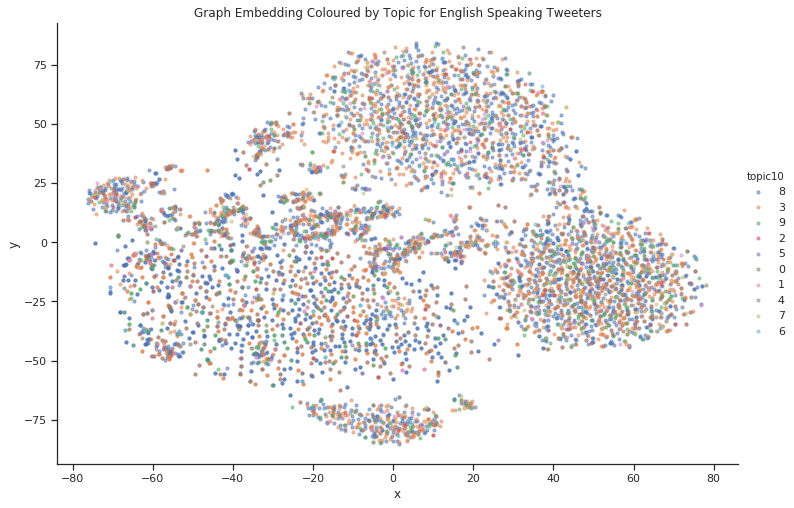

In [135]:
data_to_plot = en_data[en_data["topic10"] != "not_available"]
plot_grouped_embedding(data_to_plot, 'topic10', 'Graph Embedding Coloured by Topic for English Speaking Tweeters')
#Word2Vec vector size 20

In the above graph, each point is a Twitter user that uses English language in tweets, and their location in the graph is determined by the 2-dimensional embedding output from the Node2Vec and t-SNE algorithms. Clusters, based on the Node2Vec algorithm that maximises the likelihood of user neighbours in the graph, can be observed. 

The users are coloured by the most prominent topic used in tweets. Topics appear uniformly across all the clusters, with no obvious groupings of users by topic.

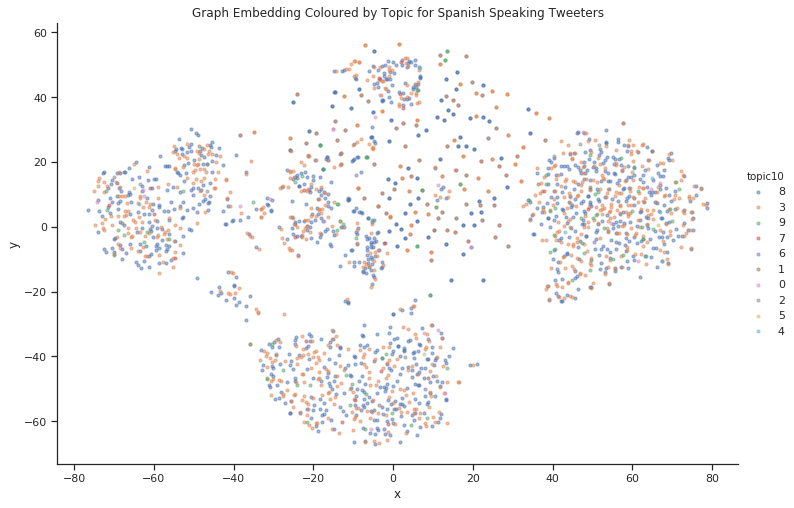

In [138]:
#word2vec size is 20
data_to_plot = es_data[es_data["topic10"] != "not_available"]
plot_grouped_embedding(data_to_plot, 'topic10', 'Graph Embedding Coloured by Topic for Spanish Speaking Tweeters')

For the graph of Spanish users one coloured by the most prominent topic used in tweets. Topics appear uniformly across all the clusters, with no obvious groupings of users by topic.